In [ ]:
import pandas as pd
import os
import sqlite3
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

dataset_name = "OurData_Labeled"
is_labeled = True

data_dir = f'/content/drive/MyDrive/Blink Detection/Datasets/{dataset_name}'
db_name = f'/content/drive/MyDrive/Blink Detection/Datasets/{dataset_name}.db'

print("Data directory:", data_dir)
print("Database name:", db_name)
files = [f for f in os.listdir(data_dir) if f.endswith('.csv') and '_labels' not in f]
all_data = []
conn = sqlite3.connect(db_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data directory: /content/drive/MyDrive/School/7/SYSC 4907A - Engineering Project/FreshStart/Datasets/OurData_Labeled
Database name: /content/drive/MyDrive/School/7/SYSC 4907A - Engineering Project/FreshStart/Datasets/OurData_Labeled.bd
Columns in 2025_02_19_Data1(NRS).csv : ['Time (s)', 'Voltage (V)']


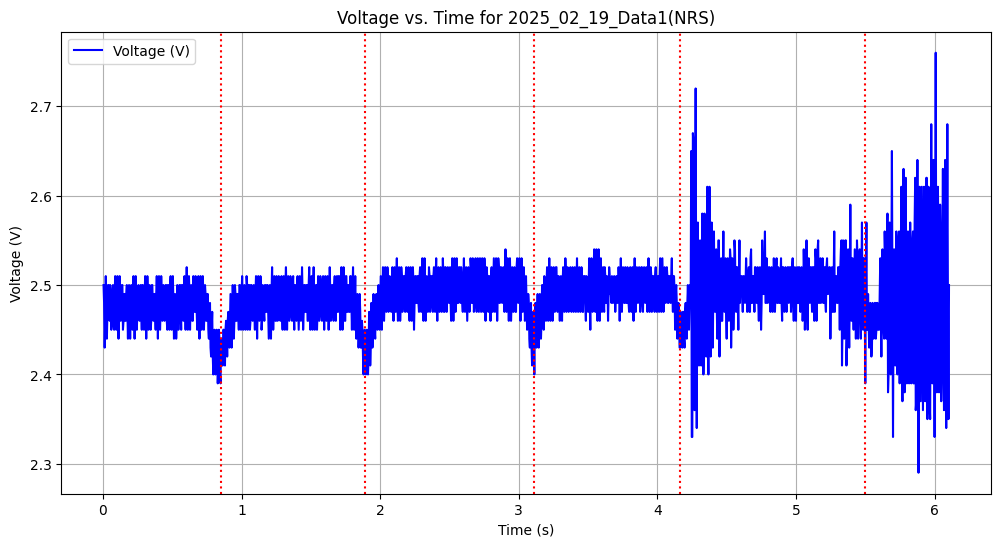

Columns in 2025_03_05_Data1(N5S).csv : ['Time (s)', 'Voltage (V)']


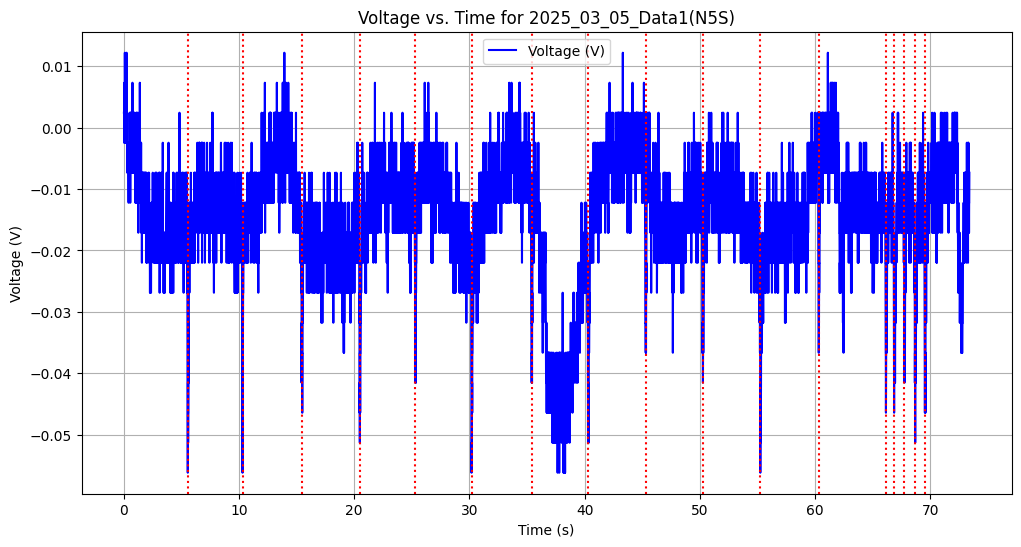

Columns in 2025_03_19_Data1(NRS).csv : ['Time (s)', 'Voltage (V)']


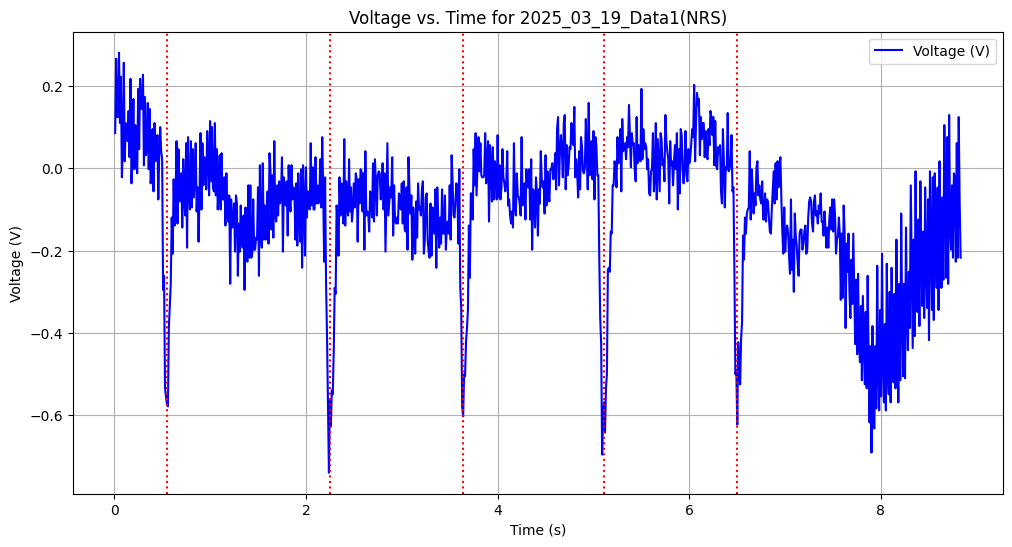


Displaying a section of the consolidated DataFrame:
   Time (s)  Voltage (V)                Dataset  Blink
0     0.004         2.50  2025_02_19_Data1(NRS)      0
1     0.008         2.48  2025_02_19_Data1(NRS)      0
2     0.012         2.43  2025_02_19_Data1(NRS)      0
3     0.016         2.46  2025_02_19_Data1(NRS)      0
4     0.020         2.51  2025_02_19_Data1(NRS)      0
5     0.024         2.47  2025_02_19_Data1(NRS)      0
6     0.028         2.44  2025_02_19_Data1(NRS)      0
7     0.032         2.47  2025_02_19_Data1(NRS)      0
8     0.036         2.50  2025_02_19_Data1(NRS)      0
9     0.040         2.50  2025_02_19_Data1(NRS)      0
All data successfully loaded and saved to the database.


In [ ]:
# Loop through each file in the data directory and pullout it's name
for file in files:
    file_path = os.path.join(data_dir, file)
    data = pd.read_csv(file_path)

    data.columns = data.columns.str.strip()
    print("Columns in", file, ":", list(data.columns))
    individual_dataset_name = os.path.splitext(file)[0]
    data['Dataset'] = individual_dataset_name

    # If the file is named this will pull out it's labeled file and then
    if is_labeled:
        labels_file = individual_dataset_name + "_labels.csv"
        labels_path = os.path.join(data_dir, labels_file)
        if os.path.exists(labels_path):
            labels_df = pd.read_csv(labels_path)
            blink_times = labels_df['time'].tolist()
            data['Blink'] = 0
            for blink in blink_times:
                available_indices = data.index[data['Blink'] == 0]
                if len(available_indices) == 0:
                    continue
                differences = abs(data.loc[available_indices, "Time (s)"] - blink)
                closest_idx = differences.idxmin()
                data.at[closest_idx, 'Blink'] = 1
            blink_count = data['Blink'].sum()
            if blink_count != len(blink_times):
                print(f"Warning: For file {file}, expected {len(blink_times)} blink(s) but only marked {blink_count}.")
        else:
            print(f"Labels file {labels_file} not found for {file}. Setting Blink to 0 for all rows.")
            data['Blink'] = 0

    # If the file isn't labeled just set everything to 0
    else:
        data['Blink'] = 0

    # Name the table like the dataset and then plot the figure to ensure everything has uploaded correcly
    table_name = individual_dataset_name
    data.to_sql(table_name, conn, if_exists='replace', index=False)

    plt.figure(figsize=(12, 6))
    plt.plot(data['Time (s)'], data['Voltage (V)'], label='Voltage (V)', color='blue')
    if is_labeled:
        blink_times_in_data = data.loc[data['Blink'] == 1, "Time (s)"]
        for blink_time in blink_times_in_data:
            plt.axvline(x=blink_time, color='red', linestyle='dotted')

    plt.title(f'Voltage vs. Time for {individual_dataset_name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.grid(True)
    plt.legend()
    plt.show()
    all_data.append(data)

consolidated_data = pd.concat(all_data, ignore_index=True)
print("\nDisplaying a section of the consolidated DataFrame:")
print(consolidated_data.head(10))
conn.close()
print("All data successfully loaded and saved to the database.")